# LIGHTCURVE ANALYSIS

We select a subsample of observations from the internal CTAO SDC of the source MRK 421. This is a time-varying source and the aim of this tutorial is to build a lightcurve with the available data.
Let's start with the basic imports:

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.datasets import MapDataset, Datasets, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.estimators.utils import get_rebinned_axis
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.modeling.models import (
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

In [2]:
# we need to set the path of the IRF:
#%env CALDB=../caldb/

We select all the observations through the `DataStore` class and we pick only observations enclosed into a search cone of 5 degrees around the given pointing position:

In [3]:
data_store = DataStore.from_dir("../output")

In [4]:
#source coordinates
ra, dec = 166.11380868146 * u.deg, 38.20883291552 * u.deg 
target = SkyCoord(166.11380868146 * u.deg, 38.20883291552 * u.deg, frame="icrs")

#pointing coordinates
pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pointing.ra.deg,
    lat=pointing.dec.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [11]:
# we select 50 observations:
selected_obs_table = selected_obs_table[0:50]

observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(f"Selected observations: {len(observations)}")
print(f"\n\nLet's have a look at the first observation \n\n: {observations[0]}")

Selected observations: 50


Let's have a look at the first observation 

: Observation

	obs id            : 5000000063 
 	tstart            : 61774.25
	tstop             : 61774.26
	duration          : 445.00 s
	pointing (icrs)   : 166.1 deg, 38.9 deg

	deadtime fraction : 0.0%



As a quality check, we may create a counts map of the observed region. Hence, we can create a dataset and we fill it with the observed events. We start by definining the geometry and select the events that satisfy our requirements:

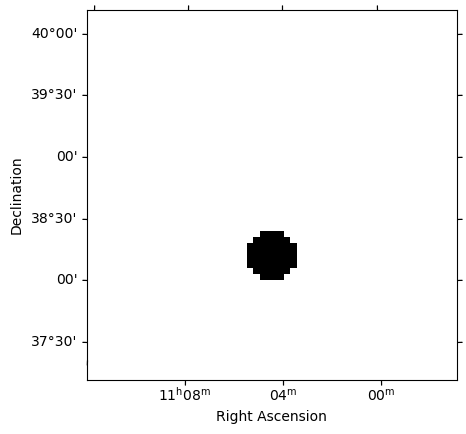

In [19]:
exclusion_geom = WcsGeom.create(
    npix=(60, 60), binsz=0.05, skydir=pointing.icrs, proj="TAN", frame="icrs"
)


exclusion_src1 = CircleSkyRegion(
    center=SkyCoord(166.11380868146, 38.20883291552, unit="deg", frame="icrs"),
    radius=0.2 * u.deg,
)

exclusion_mask = ~exclusion_geom.region_mask([exclusion_src1])
exclusion_mask.plot()
plt.show()

In [20]:
energy_axis = MapAxis.from_energy_bounds(0.012, 10.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(pointing.ra.deg , pointing.dec.deg),
    binsz=0.01,
    width=(3, 3),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

In [21]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="src"
)

In [22]:
offset_max = 3 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], aeff_percent=10, offset_max=offset_max
)

maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

Finally, we stack all the datasets into a single `dataset` object:

In [23]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 50, Background norm obs 5000000063: 1.12
1 of 50, Background norm obs 5000000064: 1.06
2 of 50, Background norm obs 5000000065: 1.08
3 of 50, Background norm obs 5000000066: 1.09
4 of 50, Background norm obs 5000000130: 1.08
5 of 50, Background norm obs 5000000131: 1.08
6 of 50, Background norm obs 5000000132: 1.09
7 of 50, Background norm obs 5000000133: 1.12
8 of 50, Background norm obs 5000000181: 1.07
9 of 50, Background norm obs 5000000183: 1.06
10 of 50, Background norm obs 5000000184: 1.09
11 of 50, Background norm obs 5000000185: 1.12
12 of 50, Background norm obs 5000000302: 1.08
13 of 50, Background norm obs 5000000303: 1.08
14 of 50, Background norm obs 5000000304: 1.11
15 of 50, Background norm obs 5000000306: 1.06
16 of 50, Background norm obs 5000000503: 1.08
17 of 50, Background norm obs 5000000504: 1.03
18 of 50, Background norm obs 5000000505: 1.08
19 of 50, Background norm obs 5000000506: 1.09
20 of 50, Background norm obs 5000000658: 1.07
21 of 50, Background no

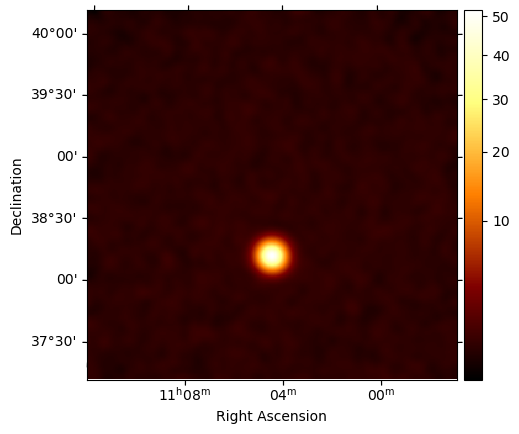

In [24]:
stacked.counts.sum_over_axes().smooth(0.04 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

# Make a lightcurve

To build a lightcurve, we should firstly define the time bin where the lightcurve has to be estimated:

In [26]:
# define the time intervals
t0 = observations[0].tstart
tstop = observations[-1].tstop
duration = 30 * u.min
n_time_bins = int( ((tstop-t0)).to("s") / duration) + 10
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]

We can filter all the observations that satisfy the temporal requirements:

In [27]:
short_observations = observations.select_time(time_intervals)

# check that observations have been filtered
print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 60

GTI info:
- Number of GTIs: 1
- Duration: 450.0000002095476 s
- Start: 883894351.174 s MET
- Start: 2028-01-04T06:11:21.990 (time standard: UTC)
- Stop: 883894801.1740001 s MET
- Stop: 2028-01-04T06:18:51.990 (time standard: UTC)



We need to select the events by energy, and we could perform an ON-OFF analysis of the source. In this case, we will adopt the reflected region method:

In [28]:
# Target definition
energy_axis = MapAxis.from_energy_bounds("0.012 TeV", "10 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.001 TeV", "20 TeV", nbin=20, name="energy_true"
)

on_region_radius = Angle("0.10 deg")
on_region = CircleSkyRegion(center=target, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [29]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [30]:
datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

The model used for the data-analisys can be estimated with a powerlaw. Below, there is only a guess:

In [31]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="MRK 421")

In [32]:
datasets.models = sky_model

And now, make the lightcurve over the time bins defined above for `MRK 421`, using the Gammapy class `LightCurveEstimator`:

In [33]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.02, 10] * u.TeV,
    source="MRK 421",
    time_intervals=time_intervals,
    selection_optional="all",
)
lc_maker_1d.norm.scan_max = 10

In [34]:
lc_1d = lc_maker_1d.run(datasets)

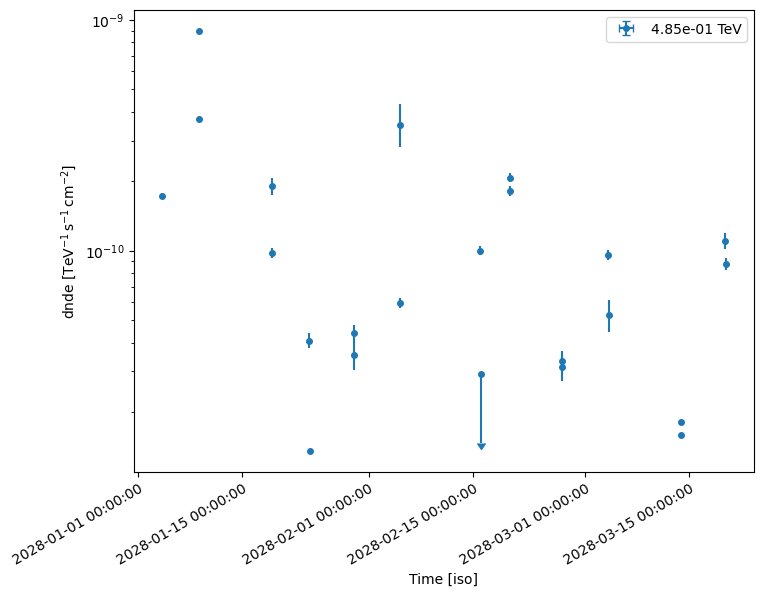

In [35]:
plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o")
plt.show()

<Axes: xlabel='Time [iso]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

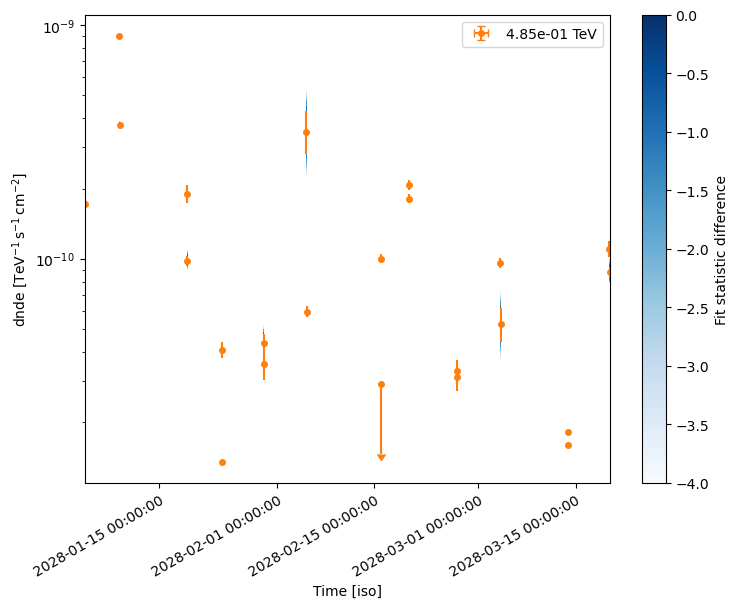

In [22]:
# if we want to inspect the significance of the points:
fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)

lc_1d.plot(ax=ax, color="tab:orange")
lc_1d.plot_ts_profiles()